In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from torch.distributions import Categorical

In [2]:
GAMMA = 0.99
MAX_EPISODES = 10000
EARLY_STOP_THRESHOLD = 480
EPISODES_EARLY_STOP = 30
NUM_NEURONS = 128
ALPHA = 0.1

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
class PolicyNet(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(PolicyNet, self).__init__()
        
        self.dense = nn.Sequential(
            nn.Linear(input_shape, NUM_NEURONS),
            nn.ReLU(),
            nn.Linear(NUM_NEURONS, NUM_NEURONS),
            nn.ReLU(),
            nn.Linear(NUM_NEURONS, n_actions),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.dense(x)

In [5]:
def update():

    global reward_baseline
    
    G = 0
    returns = []
    #print(f"temp_buffer: {temp_buffer.get_data()}")
    for _, _, reward in reversed(temp_buffer.get_data()):  # Itera all’indietro sulle transizioni salvate
        G = reward + GAMMA * G
        returns.insert(0, G)  # Salva il return in ordine corretto

    # Converti le liste in tensori per il modello
    states, actions, _ = zip(*temp_buffer.get_data())
    returns = torch.tensor(returns, dtype=torch.float32)

    loss_tot = 0

    for state, action, G in zip(states, actions, returns):

        action_probs = policy_net(state)  # Ottieni le probabilità delle azioni
        dist = Categorical(action_probs)  # Crea una distribuzione
        log_prob = dist.log_prob(action)  # Ottieni il logaritmo della probabilità dell’azione
        adv = G - reward_baseline  # Calcola l’avantage
        loss_tot += log_prob * adv

    reward_baseline = ALPHA * returns.mean().item() + (1 - ALPHA) * reward_baseline

    optimizer.zero_grad()
    loss = -loss_tot
    loss.backward()
    optimizer.step()

    return loss.item()

In [6]:
class TemporaryBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
    
    def add(self, experience):
        self.buffer.append(experience)

    def reset(self):
        self.buffer.clear()

    def get_data(self):
        return list(self.buffer)

    def __len__(self):
        return len(self.buffer)

In [7]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

policy_net = PolicyNet(env.observation_space.shape[0], env.action_space.n)
temp_buffer = TemporaryBuffer(maxlen=500)

optimizer = optim.Adam(policy_net.parameters(), lr=0.0001)
#optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

In [8]:
episode_rewards = []
loss_values = []
reward_baseline = 0

for episode in range(MAX_EPISODES):

    temp_buffer.reset()
    #print(f"temp_buffer after reset: {temp_buffer.get_data()}")

    observation, _ = env.reset(seed=SEED)
    state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

    episode_reward = 0

    stop_training = False

    for t in range(1000):   # Max steps per episode of the environment is 500
        
        action_probs = policy_net(state)  # Ottieni le probabilità delle azioni
        dist = Categorical(action_probs)  # Crea una distribuzione
        action = dist.sample()  # Esegui un sample dalla distribuzione
        next_observation, reward, done, truncated, _ = env.step(action.item())
        next_state = torch.tensor(next_observation, dtype=torch.float32).unsqueeze(0)

        done = done or truncated

        temp_buffer.add((state, action, reward))

        if episode % EPISODES_EARLY_STOP == 0:
            mean_reward = np.mean(episode_rewards[episode-EPISODES_EARLY_STOP:episode])
            if mean_reward > EARLY_STOP_THRESHOLD:
                print(f"Early stopping: average reward over last {EPISODES_EARLY_STOP} episodes is {mean_reward}")
                stop_training = True
                break

        episode_reward += reward

        state = next_state

        if done:
            print(f"Episode {episode} finished after {t+1} timesteps")
            break


    # Passa i dati alla funzione update per aggiornare la policy
    loss = update()
    loss_values.append(loss)

    episode_rewards.append(episode_reward)
    print(f"Episode {episode}, reward: {episode_reward}, loss: {loss}")
    
    if stop_training:
        break

env.close()

/Users/edoardozappia/opt/anaconda3/envs/mujoco-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/edoardozappia/opt/anaconda3/envs/mujoco-env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Episode 0 finished after 19 timesteps
Episode 0, reward: 19.0, loss: 124.9374008178711
Episode 1 finished after 14 timesteps
Episode 1, reward: 14.0, loss: 60.31298828125
Episode 2 finished after 24 timesteps
Episode 2, reward: 24.0, loss: 167.24093627929688
Episode 3 finished after 8 timesteps
Episode 3, reward: 8.0, loss: 10.082723617553711
Episode 4 finished after 23 timesteps
Episode 4, reward: 23.0, loss: 134.6031494140625
Episode 5 finished after 51 timesteps
Episode 5, reward: 51.0, loss: 656.2694091796875
Episode 6 finished after 16 timesteps
Episode 6, reward: 16.0, loss: 29.43356704711914
Episode 7 finished after 24 timesteps
Episode 7, reward: 24.0, loss: 97.31619262695312
Episode 8 finished after 29 timesteps
Episode 8, reward: 29.0, loss: 148.44068908691406
Episode 9 finished after 29 timesteps
Episode 9, reward: 29.0, loss: 133.65072631835938
Episode 10 finished after 19 timesteps
Episode 10, reward: 19.0, loss: 22.652488708496094
Episode 11 finished after 21 timesteps
Ep

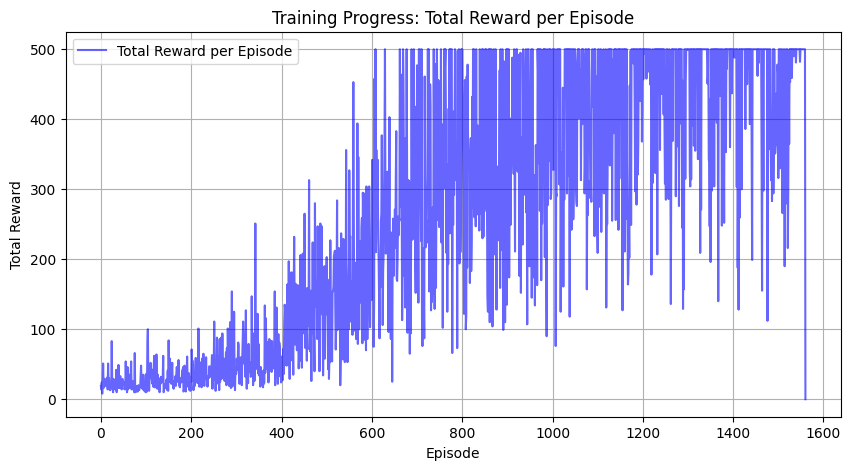

In [9]:
plt.figure(figsize=(10,5))
plt.plot(range(len(episode_rewards)), episode_rewards, label="Total Reward per Episode", color='blue', alpha=0.6)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress: Total Reward per Episode")
plt.legend()
plt.grid(True)
plt.show()

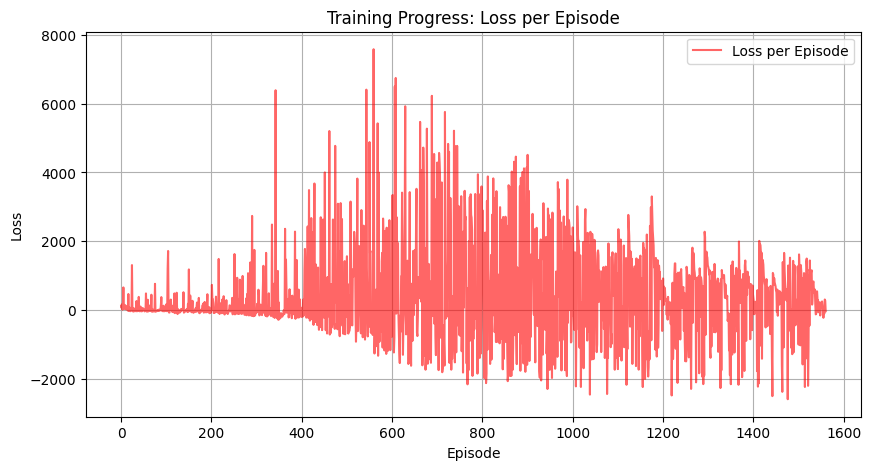

In [10]:
plt.figure(figsize=(10,5))
plt.plot(range(len(loss_values)), loss_values, label="Loss per Episode", color='red', alpha=0.6)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Training Progress: Loss per Episode")
plt.legend()
plt.grid(True)
plt.show()

reward_tot 1.0
reward_tot 2.0
reward_tot 3.0
reward_tot 4.0
reward_tot 5.0
reward_tot 6.0
reward_tot 7.0
reward_tot 8.0
reward_tot 9.0
reward_tot 10.0
reward_tot 11.0
reward_tot 12.0
reward_tot 13.0
reward_tot 14.0
reward_tot 15.0
reward_tot 16.0
reward_tot 17.0
reward_tot 18.0
reward_tot 19.0
reward_tot 20.0
reward_tot 21.0
reward_tot 22.0
reward_tot 23.0
reward_tot 24.0
reward_tot 25.0
reward_tot 26.0
reward_tot 27.0
reward_tot 28.0
reward_tot 29.0
reward_tot 30.0
reward_tot 31.0
reward_tot 32.0
reward_tot 33.0
reward_tot 34.0
reward_tot 35.0
reward_tot 36.0
reward_tot 37.0
reward_tot 38.0
reward_tot 39.0
reward_tot 40.0
reward_tot 41.0
reward_tot 42.0
reward_tot 43.0
reward_tot 44.0
reward_tot 45.0
reward_tot 46.0
reward_tot 47.0
reward_tot 48.0
reward_tot 49.0
reward_tot 50.0
reward_tot 51.0
reward_tot 52.0
reward_tot 53.0
reward_tot 54.0
reward_tot 55.0
reward_tot 56.0
reward_tot 57.0
reward_tot 58.0
reward_tot 59.0
reward_tot 60.0
reward_tot 61.0
reward_tot 62.0
reward_tot 63.0
r

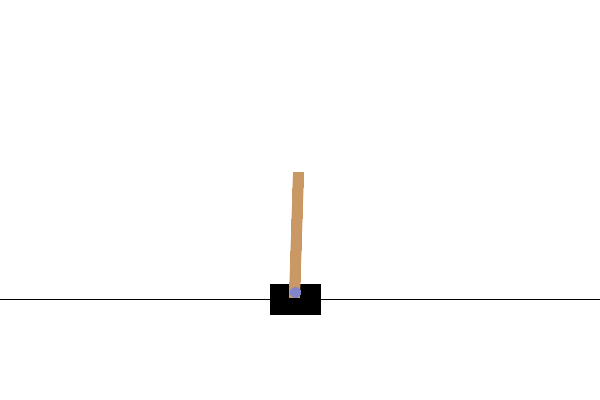

In [11]:
import gym
import torch
import imageio
import numpy as np
import matplotlib.pyplot as plt

def test_agent_and_create_gif(model, env, filename="cartpole_reinforce_baseline_test_correct.gif"):
    reward_tot = 0
    frames = []
    observation, _ = env.reset()
    state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
    
    done = False
    while not done:
        # Usa il modello per selezionare l'azione migliore (greedy)
        with torch.no_grad():
            action = model(state).argmax(dim=1).item()
        
        # Esegui l'azione e salva il frame
        next_observation, reward, done, truncated, _ = env.step(action)
        frames.append(env.render())  # Salva il frame
        
        state = torch.tensor(next_observation, dtype=torch.float32).unsqueeze(0)

        reward_tot += reward

        print(f"reward_tot {reward_tot}")

        if truncated:
            break
    
    env.close()

    # Salva la GIF
    imageio.mimsave(filename, frames, fps=30)
    print(f"GIF salvata come {filename}")

    # Mostra la GIF nel notebook
    from IPython.display import display, Image
    display(Image(filename=filename))

# Testa l'agente e genera la GIF
test_agent_and_create_gif(policy_net, env)
